In [1]:
import environment.Qsim as Qsim
import torch as pt
import numpy as np

from scipy.stats import unitary_group
import plotly.express as px
from environment.Qenv_unitary import Qenv_unitary_gym

# Test Qsim

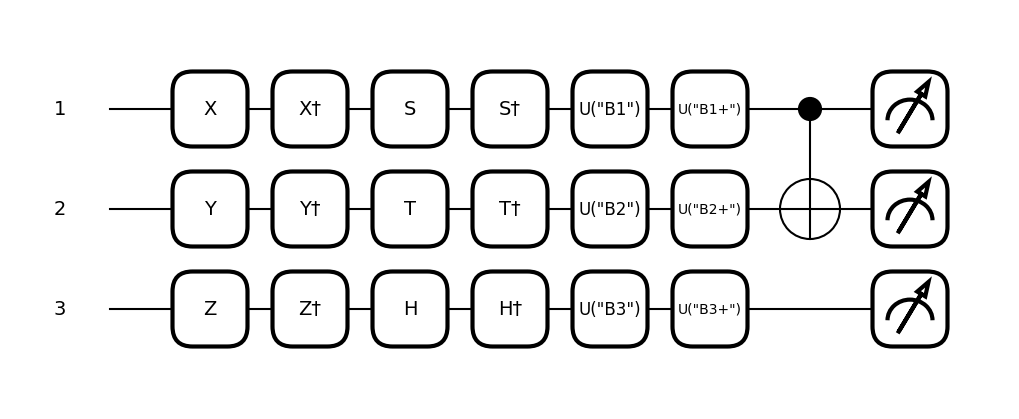

(1.0-0.0j)|000> + (-0.0+0.0j)|001> + (0.0-0.0j)|010> + (-0.0+0.0j)|011> + (0.0+0.0j)|100> + (-0.0-0.0j)|101> + (-0.0-0.0j)|110> + (0.0+0.0j)|111> 


In [2]:
# Initialize Circuit
Qcomp = Qsim.Circuit(3)

# Pauli gates
Qcomp.X(1)
Qcomp.Y(2)
Qcomp.Z(3)

# Apply adjoint gates
Qcomp.X(1, adjoint=True)
Qcomp.Y(2, adjoint=True)
Qcomp.Z(3, adjoint=True)

# Clifford + T gates
Qcomp.S(1)
Qcomp.T(2)
Qcomp.Hadamard(3)

Qcomp.S(1, adjoint=True)
Qcomp.T(2, adjoint=True)
Qcomp.Hadamard(3, adjoint=True)

# HRC gates
Qcomp.B1(1)
Qcomp.B2(2)
Qcomp.B3(3)

Qcomp.B1(1, adjoint=True)
Qcomp.B2(2, adjoint=True)
Qcomp.B3(3, adjoint=True)

# contol gates
Qcomp.CNOT([1,2])

Qcomp.draw_circuit()
print(Qcomp.state_str())

# Test Qenv

In [62]:
N = 1
target = Qsim.get_Identity(N)
env = Qenv_unitary_gym(N=N, goal=target, fidelity_function='Haar_integral', obs_type='Dict')

In [63]:
obs0, _ = env.reset()
obs0['achieved_goal'] = pt.Tensor(obs0['achieved_goal']).reshape(1,-1)
obs0['desired_goal'] = pt.Tensor(obs0['desired_goal']).reshape(1,-1)

obs1,_,_,_,_ = env.step(1)
obs1['achieved_goal'] = pt.Tensor(obs1['achieved_goal']).reshape(1,-1)
obs1['desired_goal'] = pt.Tensor(obs1['desired_goal']).reshape(1,-1)

obs2,_,_,_,_ = env.step(1)
obs2['achieved_goal'] = pt.Tensor(obs2['achieved_goal']).reshape(1,-1)
obs2['desired_goal'] = pt.Tensor(obs2['desired_goal']).reshape(1,-1)

obs3,_,_,_,_ = env.step(1)
obs3['achieved_goal'] = pt.Tensor(obs3['achieved_goal']).reshape(1,-1)
obs3['desired_goal'] = pt.Tensor(obs3['desired_goal']).reshape(1,-1)

observations = {}
observations['achieved_goal'] = pt.cat([obs0['achieved_goal'], obs1['achieved_goal'], obs2['achieved_goal'], obs3['achieved_goal']],dim=0)
observations['desired_goal'] = pt.cat([obs0['desired_goal'], obs1['desired_goal'], obs2['desired_goal'], obs3['desired_goal']],dim=0)

def flat2Cmat(tensor):
    half = int(tensor.shape[1]/2)
    size = int(np.sqrt(half))
    mat_tensor = (tensor[:,:half] + 1j * tensor[:,half:]).reshape(tensor.shape[0],size, size)
    return mat_tensor

achieved_goal = observations['achieved_goal']
desired_goal = observations['desired_goal']

achieved_goal = achieved_goal.unsqueeze(0) if achieved_goal.ndim == 1 else achieved_goal
desired_goal = desired_goal.unsqueeze(0) if desired_goal.ndim == 1 else desired_goal

achieved_goal = flat2Cmat(achieved_goal)
desired_goal = flat2Cmat(desired_goal)

obs = achieved_goal @ pt.adjoint(desired_goal)

obs = obs.reshape(obs.shape[0],-1)
obs = pt.cat([obs.real,obs.imag], dim=1)

# Test random stuff

## Get and plot states

In [5]:
def haar_states(N:int, size: int=2500) -> pt.Tensor:
    haar_matrices = unitary_group.rvs(dim=2**N,size=size)
    zero_state = np.zeros(2**N, dtype=complex).reshape(-1,1)
    zero_state[0] = 1
    random_states = pt.tensor(haar_matrices @ zero_state)
    return random_states

In [ ]:
def plot_bloch_sphere(states:np.ndarray):
    amplitudes = np.abs(states)
    angles = np.angle(states)

    theta = np.squeeze(2*np.arccos(amplitudes[:,0,:]))
    phi = np.squeeze(angles[:,0,:] - angles[:,1,:])
    r = 1

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    fig = px.scatter_3d(x=x,y=y,z=z, opacity=0.5)
    fig.update_traces(marker_size = 1)
    fig.show()

In [ ]:
plot_bloch_sphere(haar_states(1,10000))

## Haar integral

In [16]:
def Haar_integral(N:int, achieved_goal:pt.Tensor, desired_goal:pt.Tensor):
    size = 10000
    
    haar_matrices = pt.tensor(unitary_group.rvs(dim=2**N,size=size), dtype=pt.complex64)
    zero_state = pt.zeros(2**N, dtype=pt.complex64).reshape(-1,1)
    zero_state[0] = 1
    states = haar_matrices @ zero_state
    states_T = pt.conj(states.reshape(-1,1,2**N))

    if achieved_goal.ndim == 2:
        F = pt.abs((states_T @ pt.adjoint(achieved_goal) @ desired_goal @ states).flatten())**2
        integral = pt.mean(F).numpy().astype(np.float32)

    else:
        bra = states_T.unsqueeze(0) 
        bra = bra.expand(achieved_goal.shape[0], -1, -1, -1) 

        U = pt.adjoint(achieved_goal) @ desired_goal
        U = U.unsqueeze(1)

        ket = states.unsqueeze(0)  
        ket = ket.expand(achieved_goal.shape[0], -1, -1, -1)  

        braUket = bra @ U @ ket

        F = pt.abs(braUket.squeeze(-1).squeeze(-1))**2
        integral = pt.mean(F, dim=1).numpy().astype(np.float32)

    return integral

In [57]:
N = 1
size = 10
achieved_goal = pt.tensor(unitary_group.rvs(dim=2**N,size=size), dtype=pt.complex64)
desired_goal = pt.tensor(unitary_group.rvs(dim=2**N,size=size), dtype=pt.complex64)
goal = Qsim.get_Identity(N)

In [55]:
Haar_integral(N, achieved_goal, desired_goal)

array([0.34043947, 0.52275854, 0.4482248 , 0.4773377 , 0.72553474,
       0.36462593, 0.56550235, 0.38673955, 0.33544403, 0.35181734],
      dtype=float32)

In [61]:
achieved_goal[0].shape

torch.Size([2, 2])

In [67]:
np.random.randint(5)

4